In [2]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats

# Import Ngl with pyn_env active 
# import Ngl

## Need to use metPy conda env
# import metpy.calc as mpc
# from metpy.units import units

import warnings
warnings.filterwarnings('ignore')



## Read in data and do some small processing steps

In [4]:
start_time = time.time()

saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

realSfc_allCases          = pickle.load( open( saveDir+"realSfc_allCases_withInterp.p", "rb" ) )
# Drop the old HTG10 part (will add in the proper version below)
realSfc_allCases          = realSfc_allCases.isel(case=[0,1])

HMGclmDS_localReal        = pickle.load( open( saveDir+"HMGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal        = pickle.load( open( saveDir+"HTGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal10      = pickle.load( open( saveDir+"HTGclmDS_localReal10.p", "rb" ) )
HTGclmDS_localRealp5      = pickle.load( open( saveDir+"HTGclmDS_localReal0p5.p", "rb" ) )

HMGclmDS_localRealPatch   = pickle.load( open( saveDir+"HMGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch   = pickle.load( open( saveDir+"HTGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch10 = pickle.load( open( saveDir+"HTGclmDS_localRealPatch10.p", "rb" ) )
HTGclmDS_localRealPatchp5 = pickle.load( open( saveDir+"HTGclmDS_localRealPatch0p5.p", "rb" ) )

print('Loaded all the real_sfc pickle files')



Loaded all the real_sfc pickle files


In [5]:
## Add in other multiplier experiments 
realSfc_HTGp5 = pickle.load( open( saveDir+"realSfc_HTG0p5_withInterp.p", "rb" ) )
realSfc_HTGp5 = realSfc_HTGp5.assign_coords({"case": 'HTGp5'})

realSfc_HTG10 = pickle.load( open( saveDir+"realSfc_HTG10_withInterp.p", "rb" ) )
realSfc_HTG10 = realSfc_HTG10.assign_coords({"case": 'HTG10'})


list1 = set(realSfc_allCases.keys())
list2 = set(realSfc_HTGp5.keys())
list3 = set(realSfc_HTG10.keys())
sameVarsCAM = list(list1 & list2 & list3 )

realSfc_allCases = xr.concat([realSfc_allCases[sameVarsCAM],
                              realSfc_HTG10[sameVarsCAM],
                              realSfc_HTGp5[sameVarsCAM] ], "case")


In [6]:
## Large-scale forcing data:
nateForcingFileHTG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'
nateDS_HTG = xr.open_dataset(nateForcingFileHTG, decode_times='True')

nateForcingFileHMG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'
nateDS_HMG = xr.open_dataset(nateForcingFileHMG, decode_times='True')

## Convert to local time too 
nateDS_local       = nateDS_HTG.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = nateDS_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
nateDS_local = nateDS_local.assign_coords({"time": localTimes})

# Add month_day index
month_day_idx                         = pd.MultiIndex.from_arrays([nateDS_local['time.year'].values,
                                                                nateDS_local['time.month'].values, 
                                                                nateDS_local['time.day'].values])
nateDS_local.coords['year_month_day'] = ('time', month_day_idx)


In [7]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([HMGclmDS_localReal['time.year'].values,
                                                                HMGclmDS_localReal['time.month'].values, 
                                                                HMGclmDS_localReal['time.day'].values])


HMGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localRealPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localRealPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGclmDS_localReal10.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localRealPatch10.coords['year_month_day'] = ('time', month_day_idx)

HTGclmDS_localRealp5.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localRealPatchp5.coords['year_month_day'] = ('time', month_day_idx)

realSfc_allCases.coords['year_month_day']          = ('time', month_day_idx)


In [8]:
## Change some of how things are organized for optimizing performance: 
#  One giant dataset for all the different cases per surface definition 

## CLM files 
list1 = set(HMGclmDS_localReal.keys())
list2 = set(HTGclmDS_localReal10.keys())
list3 = set(HTGclmDS_localRealp5.keys())
sameVarsCLM = list(list1 & list2 & list3 )

realSfc_caseNames   = np.asarray(['HMG','HTG','HTG10','HTGp5']).astype(str)
realSfcCLM_allCases = xr.concat([HMGclmDS_localReal[sameVarsCLM],
                                 HTGclmDS_localReal[sameVarsCLM],
                                 HTGclmDS_localReal10[sameVarsCLM],
                                 HTGclmDS_localRealp5[sameVarsCLM] ], "case")
realSfcCLM_allCases = realSfcCLM_allCases.assign_coords({"case": realSfc_caseNames})


## Patch files 
list1 = set(HMGclmDS_localRealPatch.keys())
list2 = set(HTGclmDS_localRealPatch10.keys())
list3 = set(HTGclmDS_localRealPatchp5.keys())
sameVarsCLM = list(list1 & list2 & list3 )

realSfc_caseNames   = np.asarray(['HMG','HTG','HTG10','HTGp5']).astype(str)
realSfcCLMpatch_allCases = xr.concat([HMGclmDS_localRealPatch[sameVarsCLM],
                                      HTGclmDS_localRealPatch[sameVarsCLM],
                                      HTGclmDS_localRealPatch10[sameVarsCLM],
                                      HTGclmDS_localRealPatchp5[sameVarsCLM] ], "case")
realSfcCLMpatch_allCases = realSfcCLMpatch_allCases.assign_coords({"case": realSfc_caseNames})

**Only use full days [so cut off beginning/end if needed]**

In [37]:
## First day of each run 06/02 doesn't start until 6p. So drop 06/02 
## And last day of each run 8/28 only goes until about 6p, so let's drop 8/28 too. 

iDropJune = np.where( (realSfc_allCases['time.month']==6) & (realSfc_allCases['time.day']==2))[0]
iDropAug  = np.where( (realSfc_allCases['time.month']==8) & (realSfc_allCases['time.day']==28))[0]

allTimeIndices = np.arange(0,len(realSfc_allCases.time.values))
keepIndices    = np.delete(allTimeIndices, np.append(iDropJune, iDropAug))

## Now limit to those days:
realSfc_allCases         = realSfc_allCases.isel(time=keepIndices)
realSfcCLM_allCases      = realSfcCLM_allCases.isel(time=keepIndices)
realSfcCLMpatch_allCases = realSfcCLMpatch_allCases.isel(time=keepIndices)

**Get same days in obs**

In [38]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDates(fullDS, matchDatesDS):
    iTimes = []
    uniqueDates = np.unique(matchDatesDS.year_month_day.values)
    
    for iTime in range(len(uniqueDates)):
#         iKeepTimes = np.where((fullDS['time.year'] == matchDatesDS['time.year'].values[iTime]) &
#                               (fullDS['time.month']== matchDatesDS['time.month'].values[iTime]) & 
#                               (fullDS['time.day']  == matchDatesDS['time.day'].values[iTime]))[0]  
        iKeepTimes = np.where((fullDS['time.year'] == uniqueDates[iTime][0]) &
                              (fullDS['time.month']== uniqueDates[iTime][1]) & 
                              (fullDS['time.day']  == uniqueDates[iTime][2]))    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [39]:
# Get just the dates that exist in simulations
nateDS_local = getTimes_basedOnDates(nateDS_local,  realSfc_allCases)

## Assemble scatter plots

In [40]:
def getMeansForVar_noLev(DS, xVar,xStartHr,xEndHr):
    
    # Select requested hours (inclusive)
    iHours_x = np.where( (DS['time.hour']>=xStartHr) & (DS['time.hour']<=xEndHr) )[0]
    
    # Select those hours in the dataset for the requested variables 
    sel_xVar = DS.isel(time=iHours_x)[xVar]

    # For each date, get the mean value over the selected time period 
    xVar_dailyMean = sel_xVar.groupby('year_month_day').mean(dim='time')
    
    return(xVar_dailyMean)
    

In [41]:
def getMeansForVar_levRange(DS, xVar,xStartHr,xEndHr,
                            levName, xStartLev, xEndLev):    #startLev would be ~975, endLev ~800 hPa or something
    
    # Select requested hours (inclusive)
    iHours_x = np.where( (DS['time.hour']>=xStartHr) & (DS['time.hour']<=xEndHr) )[0]
    iLevs_x  = np.where( (DS[levName]>=xEndLev) & (DS[levName]<=xStartLev) )[0]
    
    # Select those hours in the dataset for the requested variables 
    sel_xVar = DS.isel(time=iHours_x)[xVar]

    # For each date, get the mean value over the selected time period 
    xVar_dailyMean1 = sel_xVar.groupby('year_month_day').mean(dim='time')
    
    if levName=='levInterp':
        xVar_dailyMean  = xVar_dailyMean1[:,:,iLevs_x,:,:].mean(dim=levName)
    elif ( (levName=='lev') & (len(DS[levName]) ==37) ):
        xVar_dailyMean  = xVar_dailyMean1[:,iLevs_x].mean(dim=levName)
    
    return(xVar_dailyMean)
    


In [42]:
## Get some useful variables (that don't require a level selection)

pblh_afternoonMean  = getMeansForVar_noLev(realSfc_allCases, 'PBLH', 12, 17)
cape_afternoonMean  = getMeansForVar_noLev(realSfc_allCases, 'CAPE', 12, 17)
tref_afternoonMean  = getMeansForVar_noLev(realSfc_allCases, 'TREFHT', 12, 17)
qref_afternoonMean  = getMeansForVar_noLev(realSfc_allCases, 'QREFHT', 12, 17)
shflx_afternoonMean = getMeansForVar_noLev(realSfc_allCases, 'SHFLX', 12, 17)



In [43]:
## Get other useful variables (that *do* require a level selection)
wp2_afternoonMean = getMeansForVar_levRange(realSfc_allCases, 'WP2_CLUBB_interp',12,17,
                                            'levInterp', 1000, 800)
wpthlp_afternoonMean = getMeansForVar_levRange(realSfc_allCases, 'WPTHLP_CLUBB_interp',12,17,
                                            'levInterp', 1000, 800)
wprtp_afternoonMean = getMeansForVar_levRange(realSfc_allCases, 'WPRTP_CLUBB_interp',12,17,
                                            'levInterp', 1000, 800)


thlp2_sfc_afternoonMean   = getMeansForVar_levRange(realSfc_allCases, 'THLP2_CLUBB_interp',12,17,
                                            'levInterp', 1000, 950)
rtp2_sfc_afternoonMean    = getMeansForVar_levRange(realSfc_allCases, 'RTP2_CLUBB_interp',12,17,
                                            'levInterp', 1000, 950)
rtpthlp_sfc_afternoonMean = getMeansForVar_levRange(realSfc_allCases, 'RTPTHLP_CLUBB_interp',12,17,
                                            'levInterp', 1000, 950)


In [44]:
## Compute a few differences (HTG-HMG)
diffPBLH_HTG = pblh_afternoonMean.isel(case=np.where(pblh_afternoonMean.case=='HTG')[0]).values - pblh_afternoonMean.isel(case=np.where(pblh_afternoonMean.case=='HMG')[0]).values
diffTREF_HTG = tref_afternoonMean.isel(case=np.where(tref_afternoonMean.case=='HTG')[0]).values - tref_afternoonMean.isel(case=np.where(tref_afternoonMean.case=='HMG')[0]).values
diffSHFLX_HTG = shflx_afternoonMean.isel(case=np.where(shflx_afternoonMean.case=='HTG')[0]).values - shflx_afternoonMean.isel(case=np.where(shflx_afternoonMean.case=='HMG')[0]).values

diffWP2_HTG  = wp2_afternoonMean.isel(case=np.where(wp2_afternoonMean.case=='HTG')[0]).values   - wp2_afternoonMean.isel(case=np.where(wp2_afternoonMean.case=='HMG')[0]).values

diffTHLP2_HTG    = thlp2_sfc_afternoonMean.isel(case=np.where(thlp2_sfc_afternoonMean.case=='HTG')[0]).values      - thlp2_sfc_afternoonMean.isel(case=np.where(thlp2_sfc_afternoonMean.case=='HMG')[0]).values
diffRTP2_HTG     = rtp2_sfc_afternoonMean.isel(case=np.where(rtp2_sfc_afternoonMean.case=='HTG')[0]).values        - rtp2_sfc_afternoonMean.isel(case=np.where(rtp2_sfc_afternoonMean.case=='HMG')[0]).values
diffRTPTHLP_HTG = rtpthlp_sfc_afternoonMean.isel(case=np.where(rtpthlp_sfc_afternoonMean.case=='HTG')[0]).values  - rtpthlp_sfc_afternoonMean.isel(case=np.where(rtpthlp_sfc_afternoonMean.case=='HMG')[0]).values

diffWPTHLP_HTG  = wpthlp_afternoonMean.isel(case=np.where(wpthlp_afternoonMean.case=='HTG')[0]).values   - wpthlp_afternoonMean.isel(case=np.where(wpthlp_afternoonMean.case=='HMG')[0]).values
diffWPRTP_HTG   = wprtp_afternoonMean.isel(case=np.where(wprtp_afternoonMean.case=='HTG')[0]).values   - wprtp_afternoonMean.isel(case=np.where(wprtp_afternoonMean.case=='HMG')[0]).values



In [45]:
def plotScatter(xVar, yVar, xName, yName, xUnits, yUnits):
    fig,axs = plt.subplots(1,1, figsize=(5,5))
    
#     axs.plot(np.squeeze(xVar), np.squeeze(yVar), 'o')
    axs.scatter(np.squeeze(xVar), np.squeeze(yVar))
    
    axs.set_xlabel(xName+' ('+xUnits+')', fontsize=14)
    axs.set_ylabel(yName+' ('+yUnits+')', fontsize=14)
    
    return(axs)
    

**Scatter plots of delta PBLH vs. some environmental factors on the HMG days**

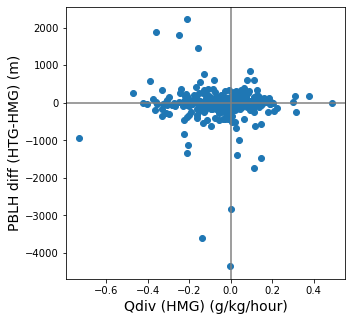

In [48]:
## Means of synoptic conditions 
qdiv_lowLev_morningMean  = getMeansForVar_levRange(nateDS_local, 'q_adv_h',4,8,
                                            'lev', 925, 800)

ax = plotScatter( qdiv_lowLev_morningMean, diffPBLH_HTG,  
            'Qdiv (HMG)', 'PBLH diff (HTG-HMG)', 
            nateDS_local.q_adv_h.units, realSfc_allCases.PBLH.units)
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

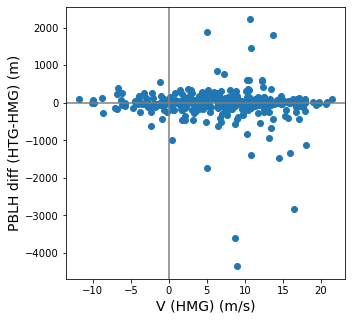

In [129]:
## Means of synoptic conditions 
v_lowLev_morningMean  = getMeansForVar_levRange(realSfc_allCases, 'V_interp',0,4,
                                            'levInterp', 925, 850)

ax = plotScatter( v_lowLev_morningMean.isel(case = np.where(v_lowLev_morningMean.case=='HMG')[0]), diffPBLH_HTG,  
            'V (HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.V_interp.units, realSfc_allCases.PBLH.units)
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


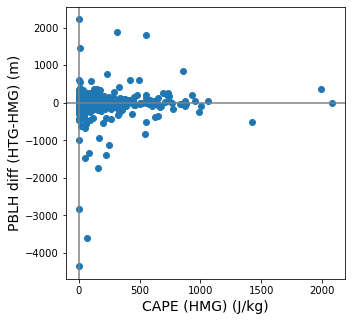

In [130]:
ax = plotScatter( cape_afternoonMean.isel(case = np.where(v_lowLev_morningMean.case=='HMG')[0]), diffPBLH_HTG,  
            'CAPE (HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.CAPE.units, realSfc_allCases.PBLH.units)
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


**Scatter plots of delta PBLH vs. some surface variables (1D)**

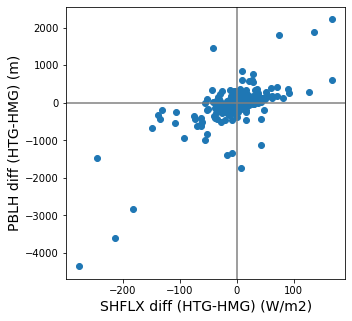

In [148]:
ax = plotScatter( diffSHFLX_HTG, diffPBLH_HTG,  
            'SHFLX diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.SHFLX.units, realSfc_allCases.PBLH.units)
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

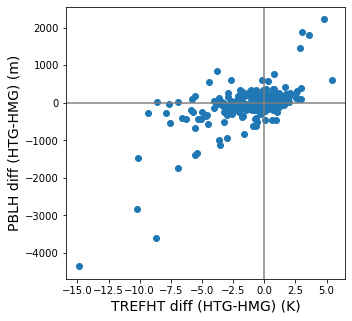

In [145]:
ax = plotScatter( diffTREF_HTG, diffPBLH_HTG,  
            'TREFHT diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.TREFHT.units, realSfc_allCases.PBLH.units)
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

**Scatter plots of delta PBLH vs. some CLUBB variables, averaged over some near-surface depth**

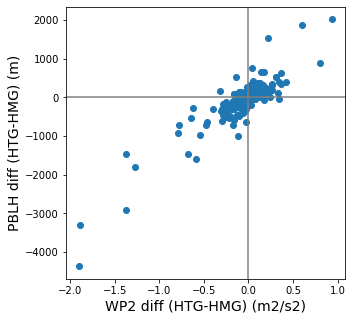

In [117]:
ax = plotScatter( diffWP2_HTG, diffPBLH_HTG,  
            'WP2 diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.WP2_CLUBB_interp.units, realSfc_allCases.PBLH.units)
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

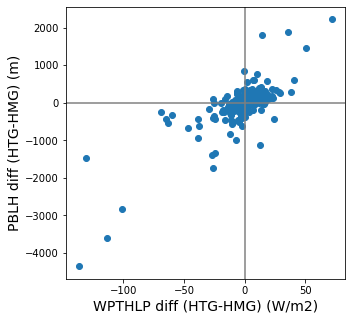

In [135]:
ax = plotScatter( diffWPTHLP_HTG, diffPBLH_HTG,  
            'WPTHLP diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.WPTHLP_CLUBB_interp.units, realSfc_allCases.PBLH.units)
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

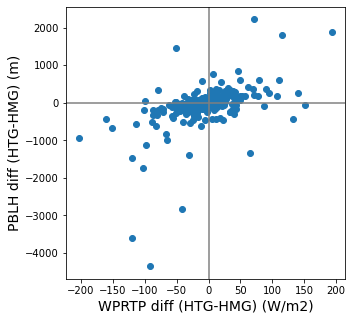

In [137]:
ax = plotScatter( diffWPRTP_HTG, diffPBLH_HTG,  
            'WPRTP diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.WPRTP_CLUBB_interp.units, realSfc_allCases.PBLH.units)
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

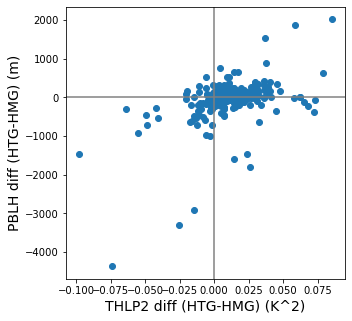

In [116]:
ax = plotScatter( diffTHLP2_HTG, diffPBLH_HTG,  
            'THLP2 diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.THLP2_CLUBB_interp.units, realSfc_allCases.PBLH.units)

ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

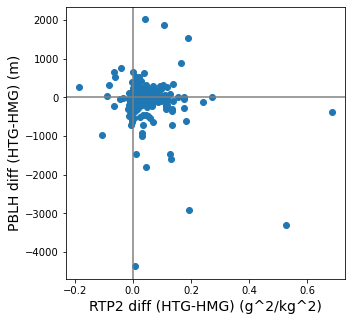

In [118]:
ax = plotScatter( diffRTP2_HTG, diffPBLH_HTG,  
            'RTP2 diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.RTP2_CLUBB_interp.units, realSfc_allCases.PBLH.units)

ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

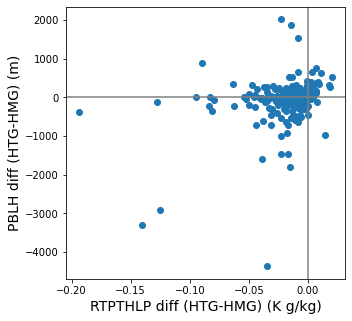

In [121]:
ax = plotScatter( diffRTPTHLP_HTG, diffPBLH_HTG,  
            'RTPTHLP diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.RTPTHLP_CLUBB_interp.units, realSfc_allCases.PBLH.units)

ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

**Scatter plots of deltas between various CLUBB variables**

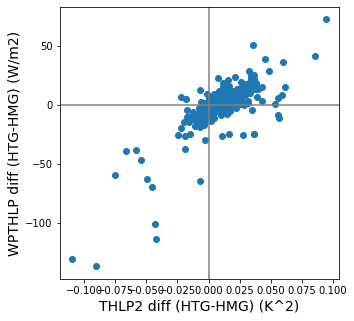

In [138]:
ax = plotScatter( diffTHLP2_HTG, diffWPTHLP_HTG,  
            'THLP2 diff (HTG-HMG)', 'WPTHLP diff (HTG-HMG)', 
            realSfc_allCases.THLP2_CLUBB_interp.units, realSfc_allCases.WPTHLP_CLUBB_interp.units)

ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

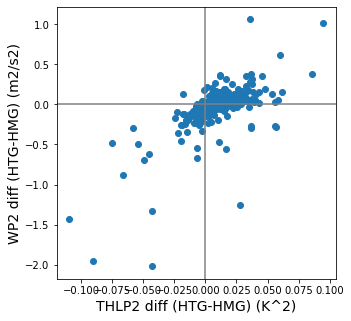

In [139]:
ax = plotScatter( diffTHLP2_HTG, diffWP2_HTG,  
            'THLP2 diff (HTG-HMG)', 'WP2 diff (HTG-HMG)', 
            realSfc_allCases.THLP2_CLUBB_interp.units, realSfc_allCases.WP2_CLUBB_interp.units)

ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

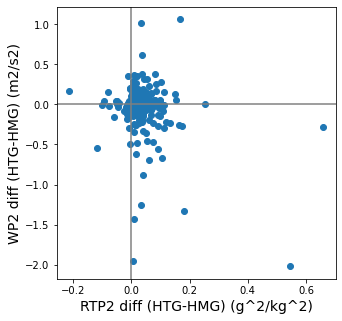

In [140]:
ax = plotScatter( diffRTP2_HTG, diffWP2_HTG,  
            'RTP2 diff (HTG-HMG)', 'WP2 diff (HTG-HMG)', 
            realSfc_allCases.RTP2_CLUBB_interp.units, realSfc_allCases.WP2_CLUBB_interp.units)

ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

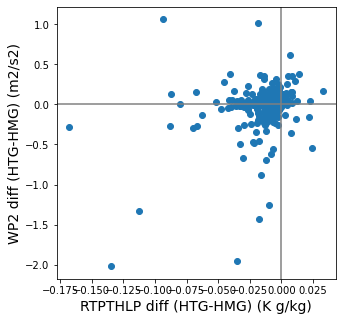

In [141]:
ax = plotScatter( diffRTPTHLP_HTG, diffWP2_HTG,  
            'RTPTHLP diff (HTG-HMG)', 'WP2 diff (HTG-HMG)', 
            realSfc_allCases.RTPTHLP_CLUBB_interp.units, realSfc_allCases.WP2_CLUBB_interp.units)

ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

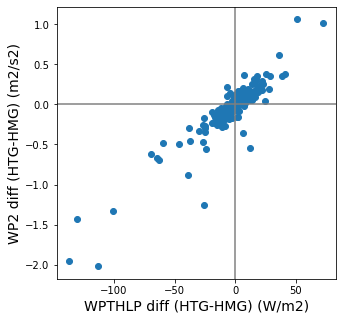

In [149]:
ax = plotScatter( diffWPTHLP_HTG, diffWP2_HTG,  
            'WPTHLP diff (HTG-HMG)', 'WP2 diff (HTG-HMG)', 
            realSfc_allCases.WPTHLP_CLUBB_interp.units, realSfc_allCases.WP2_CLUBB_interp.units)

ax.axhline(0,color='grey')
ax.axvline(0,color='grey')

**Add shading for an added dimension?**

In [116]:
def plotScatter_shade(xVar, yVar, xName, yName, xUnits, yUnits, shadeVar, shadeName, cmapSel):
    fig,axs = plt.subplots(1,1, figsize=(5,5))
    
#     axs.plot(np.squeeze(xVar), np.squeeze(yVar), 'o')

    selMax = np.nanpercentile(np.abs(shadeVar), 90)
    
    sc = axs.scatter(np.squeeze(xVar), np.squeeze(yVar), c=shadeVar, cmap = cmapSel, alpha=0.8,
                    vmax=selMax,vmin=-selMax)
    
    axs.set_xlabel(xName+' ('+xUnits+')', fontsize=14)
    axs.set_ylabel(yName+' ('+yUnits+')', fontsize=14)
    
    plt.colorbar(sc,label=shadeName)
    
    return(axs)
    

In [87]:
qdiv_lowLev_morningMean  = getMeansForVar_levRange(nateDS_local, 'q_adv_h',4,8,
                                            'lev', 950, 850)

In [100]:
v_lowLev_morningMean  = getMeansForVar_levRange(realSfc_allCases, 'V_interp',0,6,
                                               'levInterp', 950, 850)


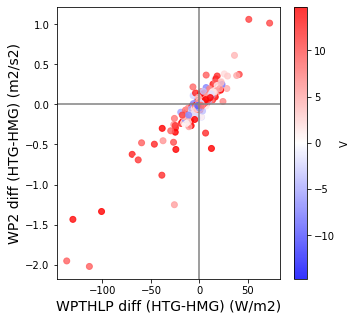

In [117]:
ax = plotScatter_shade( diffWPTHLP_HTG, diffWP2_HTG,  
            'WPTHLP diff (HTG-HMG)', 'WP2 diff (HTG-HMG)', 
            realSfc_allCases.WPTHLP_CLUBB_interp.units, realSfc_allCases.WP2_CLUBB_interp.units,
            v_lowLev_morningMean.isel(case = np.where(cape_afternoonMean.case=='HMG')[0]),'V', 'bwr')
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


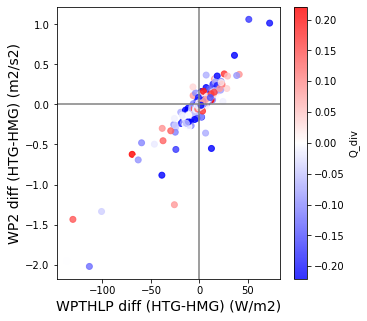

In [118]:
ax = plotScatter_shade( diffWPTHLP_HTG, diffWP2_HTG,  
            'WPTHLP diff (HTG-HMG)', 'WP2 diff (HTG-HMG)', 
            realSfc_allCases.WPTHLP_CLUBB_interp.units, realSfc_allCases.WP2_CLUBB_interp.units,
            qdiv_lowLev_morningMean,'Q_div', 'bwr')
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


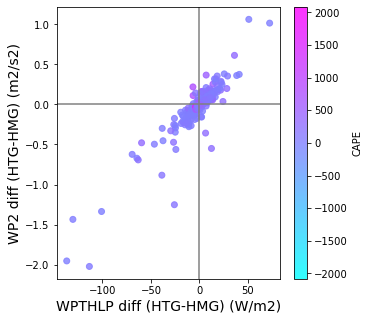

In [110]:
ax = plotScatter_shade( diffWPTHLP_HTG, diffWP2_HTG,  
            'WPTHLP diff (HTG-HMG)', 'WP2 diff (HTG-HMG)', 
            realSfc_allCases.WPTHLP_CLUBB_interp.units, realSfc_allCases.WP2_CLUBB_interp.units,
            cape_afternoonMean.isel(case = np.where(cape_afternoonMean.case=='HMG')[0]),'CAPE', 'cool')
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


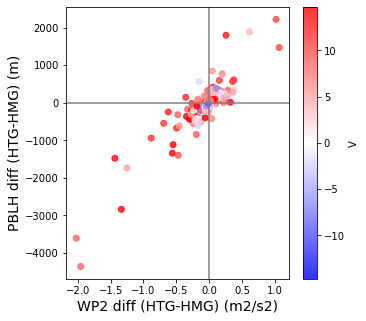

In [119]:

ax = plotScatter_shade( diffWP2_HTG, diffPBLH_HTG,  
            'WP2 diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.WP2_CLUBB_interp.units, realSfc_allCases.PBLH.units,
            v_lowLev_morningMean.isel(case = np.where(cape_afternoonMean.case=='HMG')[0]),'V', 'bwr')
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


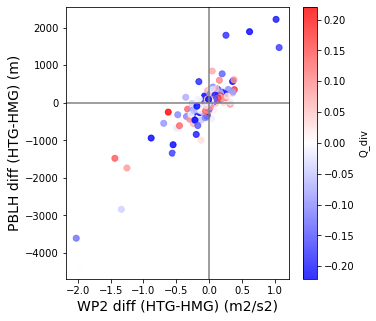

In [120]:
ax = plotScatter_shade( diffWP2_HTG, diffPBLH_HTG,  
            'WP2 diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.WP2_CLUBB_interp.units, realSfc_allCases.PBLH.units,
            qdiv_lowLev_morningMean,'Q_div', 'bwr')
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


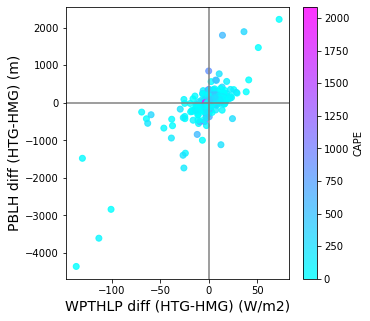

In [91]:
ax = plotScatter_shade( diffWPTHLP_HTG, diffPBLH_HTG,  
            'WPTHLP diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.WPTHLP_CLUBB_interp.units, realSfc_allCases.PBLH.units,
            cape_afternoonMean.isel(case = np.where(cape_afternoonMean.case=='HMG')[0]),'CAPE', 'cool')
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


**Shade by difference in surface moments??**

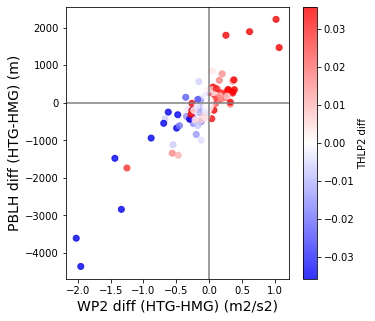

In [124]:
ax = plotScatter_shade( diffWP2_HTG, diffPBLH_HTG,  
            'WP2 diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.WP2_CLUBB_interp.units, realSfc_allCases.PBLH.units,
            diffTHLP2_HTG,'THLP2 diff', 'bwr')
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


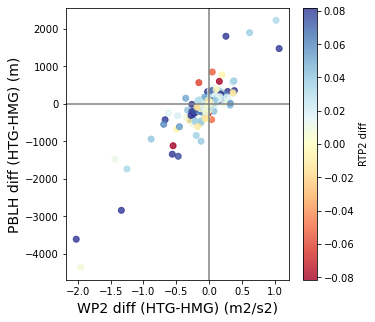

In [122]:
ax = plotScatter_shade( diffWP2_HTG, diffPBLH_HTG,  
            'WP2 diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.WP2_CLUBB_interp.units, realSfc_allCases.PBLH.units,
            diffRTP2_HTG,'RTP2 diff', 'RdYlBu')
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')


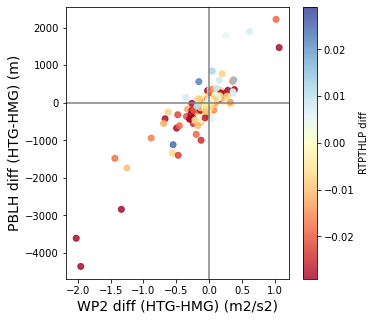

In [123]:
ax = plotScatter_shade( diffWP2_HTG, diffPBLH_HTG,  
            'WP2 diff (HTG-HMG)', 'PBLH diff (HTG-HMG)', 
            realSfc_allCases.WP2_CLUBB_interp.units, realSfc_allCases.PBLH.units,
            diffRTPTHLP_HTG,'RTPTHLP diff', 'RdYlBu')
ax.axhline(0,color='grey')
ax.axvline(0,color='grey')
